<a href="https://colab.research.google.com/github/a-chow3/STAT4996/blob/main/UVA_Baseball_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UVA Prediction Models

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change Working Directory
import os

os.chdir('/content/drive/MyDrive')

In [3]:
import pandas as pd

# Read in UVA Games File
uva_df = pd.read_csv("filtered_uva_games.csv")
uva_df['TaggedPitchType'] = uva_df['TaggedPitchType'].str.replace('ChangeUp', 'Changeup')
uva_df['ExitSpeed'] = uva_df['ExitSpeed'].fillna(0)

# Display the first 5 rows of the DataFrame
uva_df.head()

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2023-02-17,14:08:14,1,1,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2023-02-17,14:08:35,1,2,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
2,3,2023-02-17,14:08:55,1,3,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
3,4,2023-02-17,14:09:14,1,4,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
4,5,2023-02-17,14:09:35,1,5,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,High,High,NaN,NaN,NaN


#### Create Standardized Statistic (PES)

In [20]:
# Define Outcomes based on Run Value (Scaled up by 10 for interpretability)
def get_pitch_outcome_adjustment(row):
    adjustment = 0

    if row['PitchCall'] == 'StrikeSwinging':
        adjustment += 2.1  # Base value for a swinging strike
        if row['KorBB'] == 'Strikeout':
            adjustment += 2.7  # Additional value for completing the strikeout
    elif row['PitchCall'] == 'StrikeCalled':
        adjustment += 1.4  # Base value for a called strike
        if row['KorBB'] == 'Strikeout':
            adjustment += 2.7  # Additional value for completing the strikeout
    elif row['PitchCall'] == 'FoulBall':
        adjustment += 0.9  # Foul balls
    elif row['PitchCall'] == 'Ball':
        adjustment -= 1.0  # Base negative value for a ball
        if row['KorBB'] == 'Walk':
            adjustment -= 3.7  # Additional negative value for completing the walk
    elif row['PitchCall'] == 'HitByPitch':
        adjustment -= 3.7  # Hit by pitch (treated similarly to a walk)
    elif row['PitchCall'] == 'InPlay':
        if row['PlayResult'] == 'Out':
            adjustment += 2.7  # Out
        elif row['PlayResult'] == 'Single':
            adjustment -= 4.7  # Single
        elif row['PlayResult'] == 'Double':
            adjustment -= 7.8  # Double
        elif row['PlayResult'] == 'Triple':
            adjustment -= 10.2  # Triple
        elif row['PlayResult'] == 'HomeRun':
            adjustment -= 14.0  # Home run

    return adjustment

def get_exit_velocity_adjustment(row):
    if row['ExitSpeed'] < 80:
        return 2.0  # Weak contact
    elif row['ExitSpeed'] >= 95:
        return -0.5  # Hard contact
    return 0

In [21]:
def calculate_pes(row):
    base_score = 100
    pitch_outcome_adj = get_pitch_outcome_adjustment(row)
    exit_velocity_adj = get_exit_velocity_adjustment(row)

    return base_score + pitch_outcome_adj + exit_velocity_adj

uva_df['PES'] = uva_df.apply(calculate_pes, axis=1)

# Mean and SD
league_average_pes = uva_df['PES'].mean()
league_average_pes_sd = uva_df['PES'].std()

# Add Standardized Values to New Column
uva_df['StandardizedPES'] = 100 + (uva_df['PES'] - league_average_pes)
uva_df['StandardizedPES'] = uva_df['StandardizedPES'].round(2)

print(f"League Average PES: {league_average_pes}")

print(f"League Average PES SD: {league_average_pes_sd}")

League Average PES: 102.32754363558962
League Average PES SD: 2.7844946634884185


## Predict Pitch Thrown per Count
Decision Tree

In [10]:
import numpy as np

# On-base events
uva_df['OBP'] = np.where(
    (uva_df['PlayResult'].isin(['Single', 'Double', 'Triple', 'HomeRun'])) |
    (uva_df['PitchCall'] == 'HitByPitch') |
    (uva_df['PitchCall'] == 'BallCalled') & (uva_df['Balls'] == 3),
    1, 0
)


# Total bases
uva_df['TB'] = np.select(
    [
        uva_df['PlayResult'].isin(['Undefined', 'Out', 'Error, FieldersChoice',
                                   'Sacrifice', 'StolenBase', 'CaughtStealing']),
        uva_df['PlayResult'] == 'Single',
        uva_df['PlayResult'] == 'Double',
        uva_df['PlayResult'] == 'Triple',
        uva_df['PlayResult'] == 'HomeRun'
    ],
    [0, 1, 2, 3, 4],
    default=0
)

# Now calculate RC
uva_df['RC'] = uva_df['OBP'] * uva_df['TB']

### Predicting RC

In [11]:
# Create differnet Subsets based on different Matchups and Pitch Types

# Define unique values for each categorical column
pitcher_throws_values = uva_df['PitcherThrows'].unique()
batter_side_values = uva_df['BatterSide'].unique()
tagged_pitch_type_values = uva_df['TaggedPitchType'].unique()

# Create an empty dictionary to store the subset DataFrames
subset_dfs = {}

# Iterate through all combinations of categorical values
for pitcher_throws in pitcher_throws_values:
    for batter_side in batter_side_values:
        for tagged_pitch_type in tagged_pitch_type_values:
            # Create a DataFrame name based on the combination
            df_name = f"{pitcher_throws[0]}{batter_side[0]}_{tagged_pitch_type}"

            # Filter the original DataFrame to create the subset
            subset_dfs[df_name] = uva_df[
                (uva_df['PitcherThrows'] == pitcher_throws) &
                (uva_df['BatterSide'] == batter_side) &
                (uva_df['TaggedPitchType'] == tagged_pitch_type)
            ]


In [12]:
pitch_types = ['Fastball', 'Slider', 'Splitter', 'Changeup', 'Curveball', 'Undefined', 'Cutter', 'Sinker']
handedness = ['RR', 'RL', 'LR', 'LL']

for hand in handedness:
    for pitch in pitch_types:
        key = f"{hand}_{pitch}"
        if key in subset_dfs:
            shape = subset_dfs[key].shape
            print(f"Shape of {key}: {shape}")
        else:
            print(f"{key} not found in the dictionary")

Shape of RR_Fastball: (435, 172)
Shape of RR_Slider: (262, 172)
Shape of RR_Splitter: (26, 172)
Shape of RR_Changeup: (56, 172)
Shape of RR_Curveball: (87, 172)
Shape of RR_Undefined: (73, 172)
Shape of RR_Cutter: (32, 172)
Shape of RR_Sinker: (53, 172)
Shape of RL_Fastball: (359, 172)
Shape of RL_Slider: (58, 172)
Shape of RL_Splitter: (19, 172)
Shape of RL_Changeup: (177, 172)
Shape of RL_Curveball: (30, 172)
Shape of RL_Undefined: (58, 172)
Shape of RL_Cutter: (0, 172)
Shape of RL_Sinker: (62, 172)
Shape of LR_Fastball: (230, 172)
Shape of LR_Slider: (19, 172)
Shape of LR_Splitter: (0, 172)
Shape of LR_Changeup: (108, 172)
Shape of LR_Curveball: (20, 172)
Shape of LR_Undefined: (32, 172)
Shape of LR_Cutter: (0, 172)
Shape of LR_Sinker: (0, 172)
Shape of LL_Fastball: (65, 172)
Shape of LL_Slider: (54, 172)
Shape of LL_Splitter: (0, 172)
Shape of LL_Changeup: (1, 172)
Shape of LL_Curveball: (18, 172)
Shape of LL_Undefined: (15, 172)
Shape of LL_Cutter: (0, 172)
Shape of LL_Sinker: (0,

In [13]:
# Cut down the List of subset_dfs to only include dfs with 15 or more rows
subset_dfs = {key: df for key, df in subset_dfs.items() if df.shape[0] >= 20}

# Cut down RR_Undefined, RL_Undefined, LR_Undefined, LL_Undefined
for key in ['RR_Undefined', 'RL_Undefined', 'LR_Undefined', 'LL_Undefined']:
    if key in subset_dfs:
        del subset_dfs[key]

In [14]:
# Cut down columns to only include numeric columns for analysis
for df_name, df in subset_dfs.items():
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    subset_dfs[df_name] = df[numeric_cols]

In [15]:
# Keep only Selected Columns
desired_columns = [
    'Balls', 'Strikes', 'RelSpeed', 'VertRelAngle', 'SpinRate', 'SpinAxis',
    'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak',
    'PlateLocHeight', 'PlateLocSide', 'VertApprAngle', 'HorzApprAngle',
    'ExitSpeed', 'StandardizedPES' # Change Depending on model chosen
]

for df_name, df in subset_dfs.items():
    # Select only the desired columns that exist in the DataFrame
    existing_columns = [col for col in desired_columns if col in df.columns]

    # Keep only these columns in the DataFrame
    subset_dfs[df_name] = df[existing_columns]

### Runs Created Random Forest Model


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    # Check if the DataFrame is not empty
    if not df.empty:

        # Prepare data for the model
        X = df.drop('RC', axis=1)  # Features (all columns except RC)
        y = df['RC']  # Target variable (RC)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the Random Forest model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred = model.predict(X_test)

        # Evaluate the model's performance
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        print(f"Results for {df_name}:")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}")
        print(f"Important Features: {feature_importance}")
        print("-" * 20)  # Print a separator between results
    else:
        print(f"DataFrame {df_name} is empty. Skipping...")

Results for RR_Fastball:
Mean Squared Error: 0.38867126436781607
R-squared: -0.2835308900523559
Important Features:              Feature  Importance
2           RelSpeed    0.132766
15          ZoneTime    0.116706
14     HorzApprAngle    0.102391
13     VertApprAngle    0.079319
16         SpeedDrop    0.072241
9   InducedVertBreak    0.065809
6          RelHeight    0.059911
3       VertRelAngle    0.059870
12      PlateLocSide    0.058442
8          Extension    0.055816
5           SpinAxis    0.038714
7            RelSide    0.030886
4           SpinRate    0.030244
11    PlateLocHeight    0.030106
10         HorzBreak    0.024983
0              Balls    0.022382
1            Strikes    0.019412
--------------------
Results for RR_Slider:
Mean Squared Error: 0.664732075471698
R-squared: -0.07683529411764667
Important Features:              Feature  Importance
9   InducedVertBreak    0.227658
6          RelHeight    0.188262
4           SpinRate    0.159912
14     HorzApprAngle    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering  # Import for clustering

# Function to perform hierarchical clustering and plot scatterplot
def perform_hierarchical_clustering(df, feature, name):
    # Select the top feature and RC
    data = df[[feature, 'RC']]

    # Replace infinite values with NaN
    data = data.replace([np.inf, -np.inf], np.nan)

    # Drop rows with NaN values
    data = data.dropna()

    # Standardize the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform hierarchical clustering
    n_clusters = 3  # You can adjust the number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = clustering.fit_predict(data_scaled)

    # Plot the scatterplot
    plt.figure(figsize=(10, 7))
    plt.scatter(data[feature], data['RC'], c=clusters, cmap='viridis')
    plt.title(f'Hierarchical Clustering Scatterplot for {name}\nFeatures: {feature} and RC')
    plt.xlabel(feature)
    plt.ylabel('RC')
    plt.savefig(f'scatterplot_{name}.png')  # Save the plot as PNG
    plt.close()

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    # Check if the DataFrame is not empty and has at least 2 samples
    if not df.empty and len(df) >= 2:
        print(f"Processing {df_name}...")

        # Prepare data for the model
        X = df.drop('RC', axis=1)  # Features (all columns except RC)
        y = df['RC']  # Target variable (RC)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the Random Forest model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Get feature importances
        feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        # Get the top feature
        top_feature = feature_importance.iloc[0]['Feature']

        # Perform hierarchical clustering
        perform_hierarchical_clustering(df, top_feature, df_name)

        print(f"Clustering completed for {df_name}. Scatterplot saved as scatterplot_{df_name}.png")
        print("-" * 20)  # Print a separator between results
    else:
        print(f"DataFrame {df_name} is empty or has insufficient samples. Skipping...")

Processing RR_Fastball...
Clustering completed for RR_Fastball. Dendrogram saved as dendrogram_RR_Fastball.png
--------------------
Processing RR_Slider...
Clustering completed for RR_Slider. Dendrogram saved as dendrogram_RR_Slider.png
--------------------
Processing RR_Splitter...
Clustering completed for RR_Splitter. Dendrogram saved as dendrogram_RR_Splitter.png
--------------------
Processing RR_Changeup...
Clustering completed for RR_Changeup. Dendrogram saved as dendrogram_RR_Changeup.png
--------------------
Processing RR_Curveball...
Clustering completed for RR_Curveball. Dendrogram saved as dendrogram_RR_Curveball.png
--------------------
Processing RR_Cutter...
Clustering completed for RR_Cutter. Dendrogram saved as dendrogram_RR_Cutter.png
--------------------
Processing RR_Sinker...
Clustering completed for RR_Sinker. Dendrogram saved as dendrogram_RR_Sinker.png
--------------------
Processing RL_Fastball...
Clustering completed for RL_Fastball. Dendrogram saved as dendrog

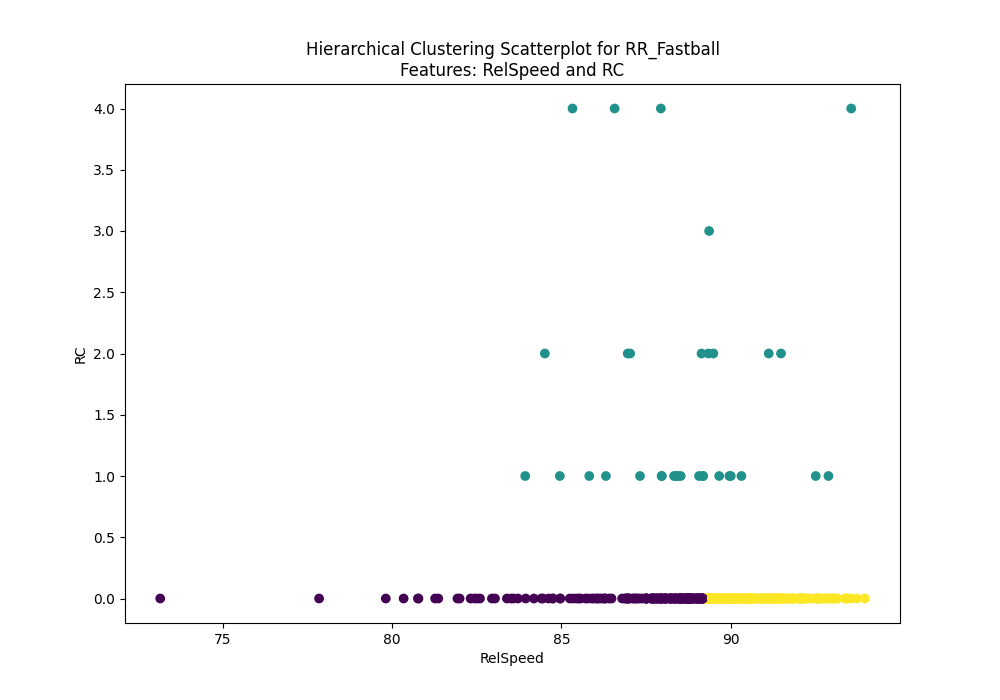

Scatterplot for RR_Fastball


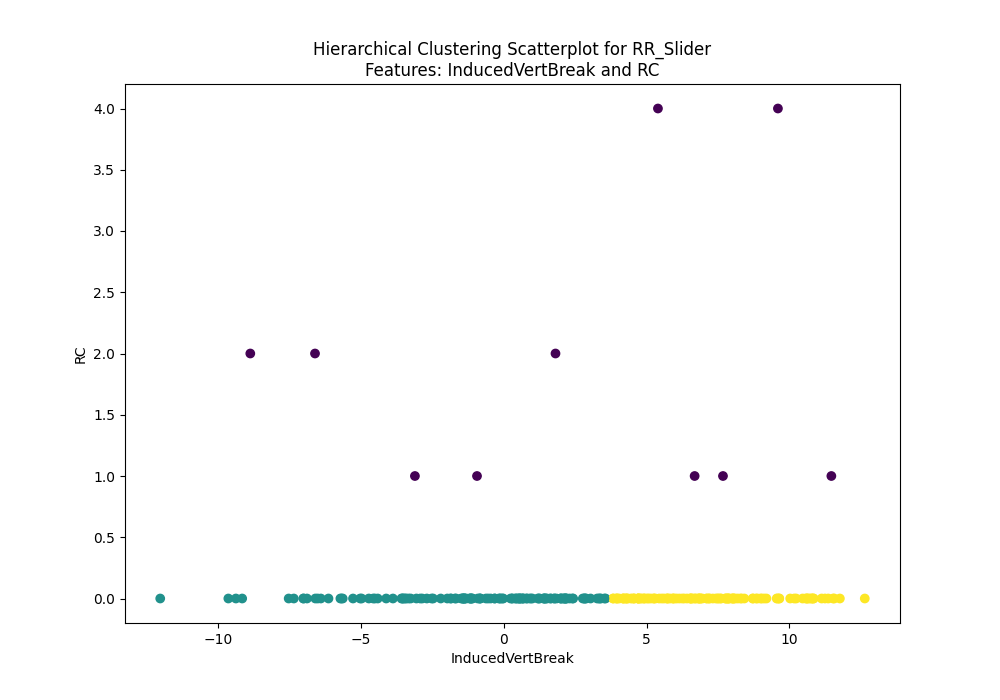

Scatterplot for RR_Slider


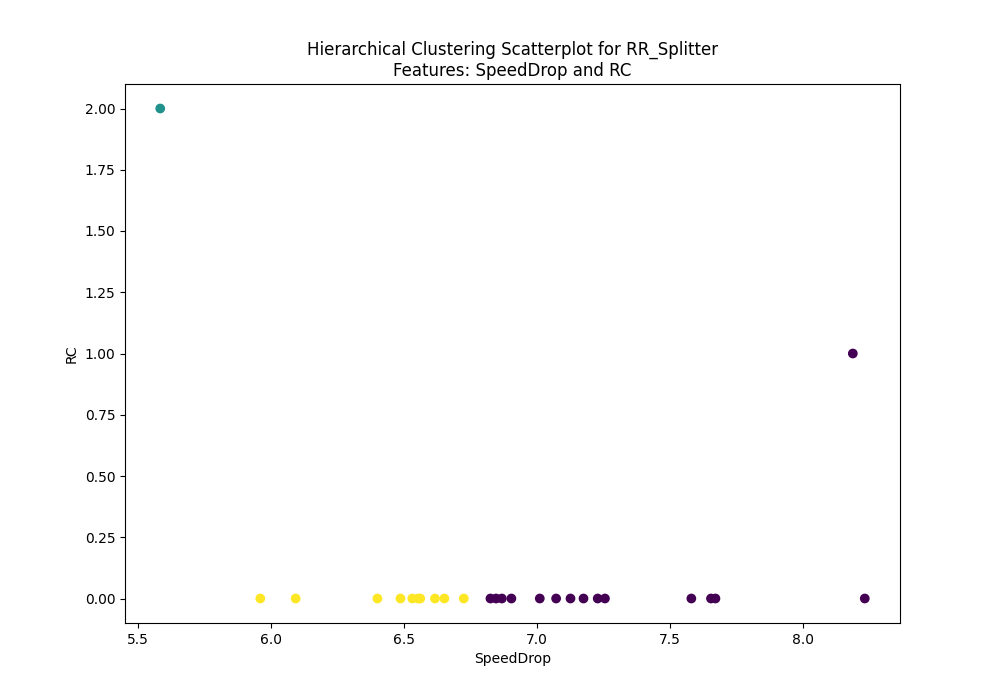

Scatterplot for RR_Splitter


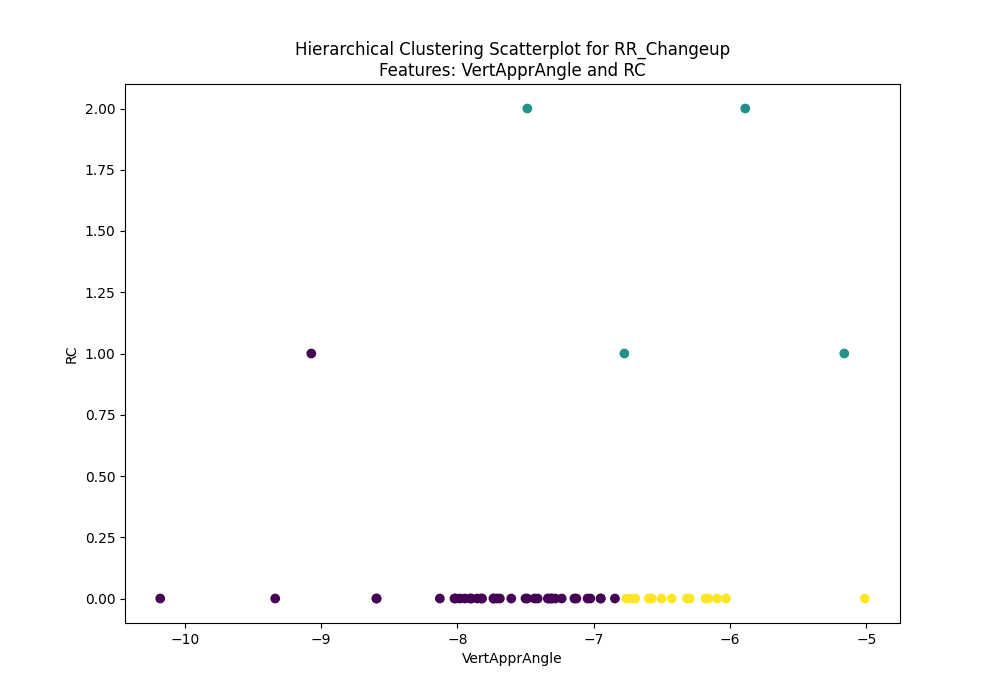

Scatterplot for RR_Changeup


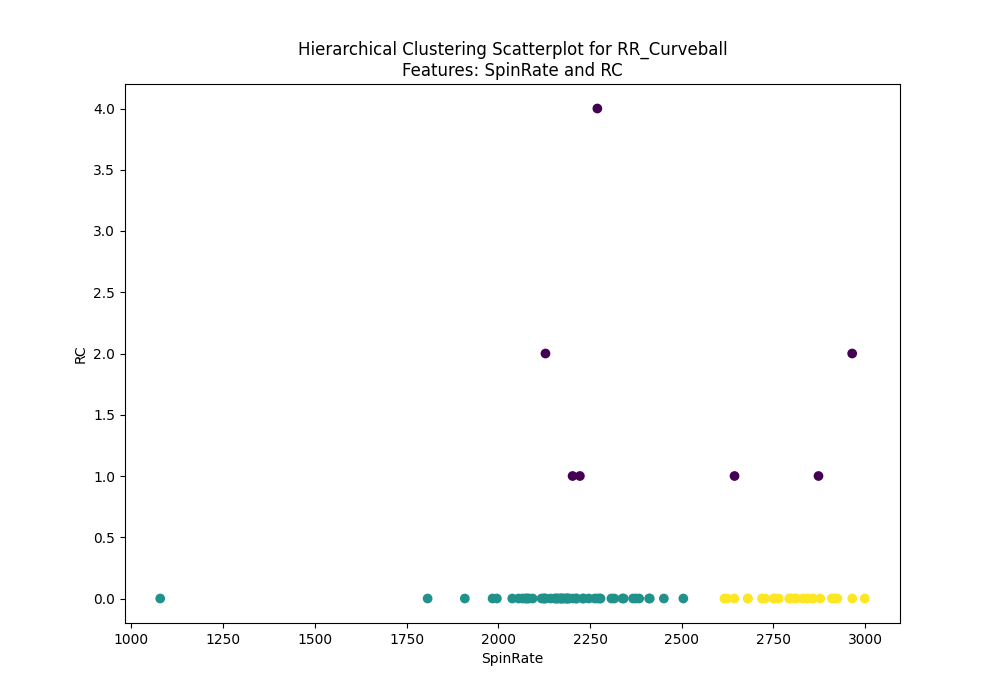

Scatterplot for RR_Curveball


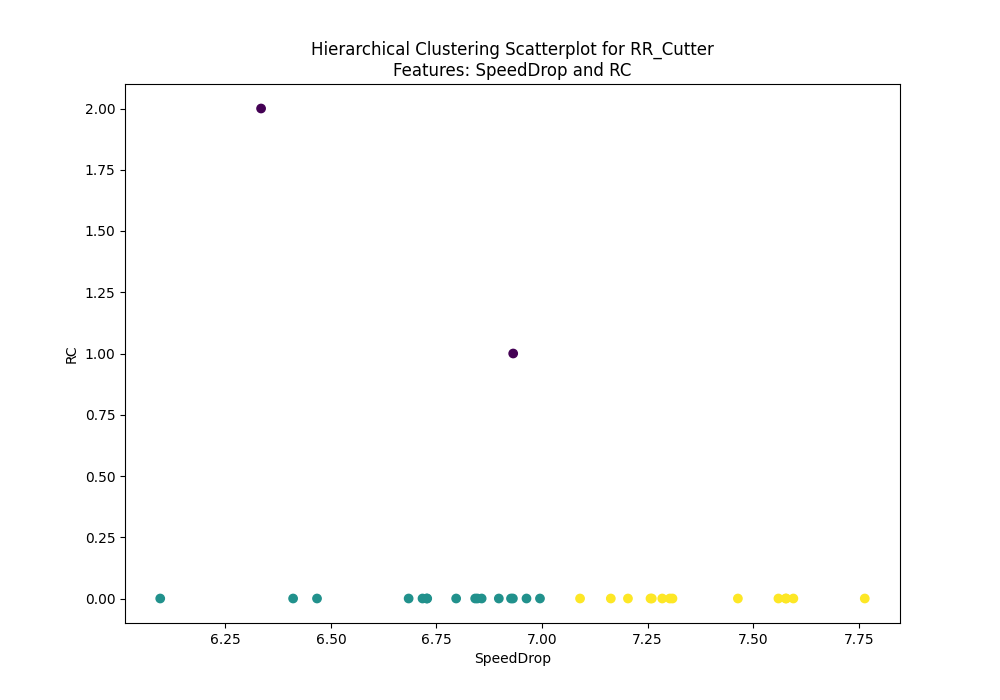

Scatterplot for RR_Cutter


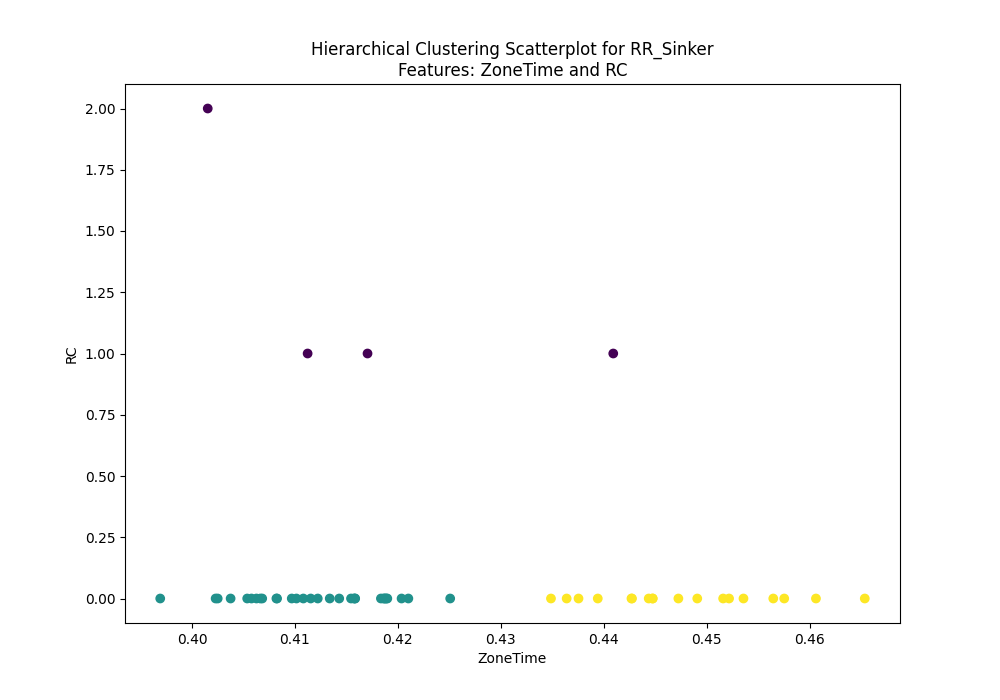

Scatterplot for RR_Sinker


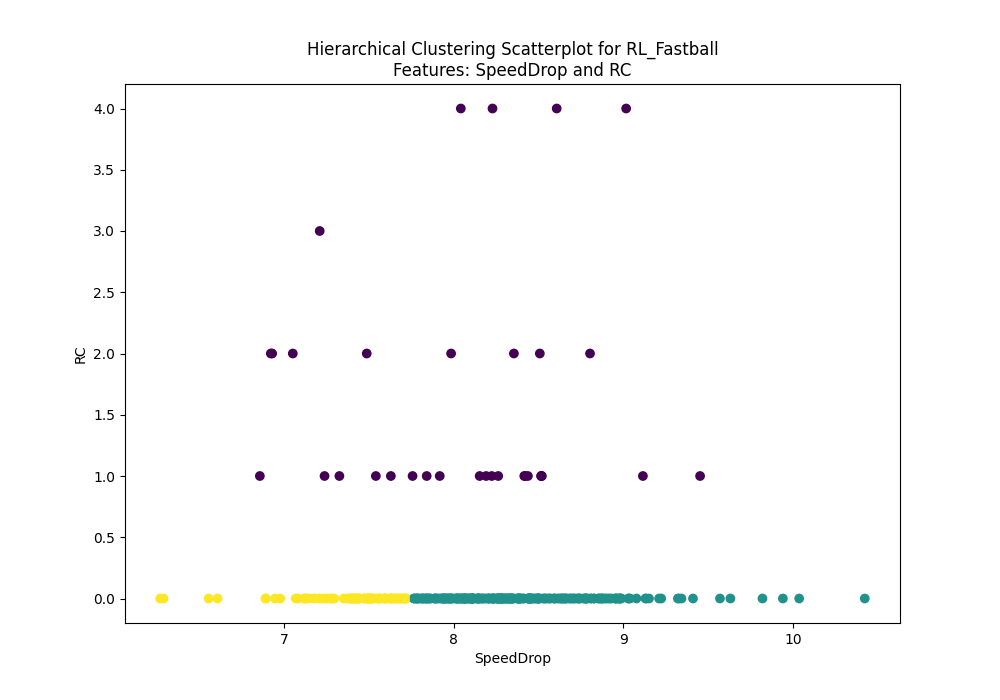

Scatterplot for RL_Fastball


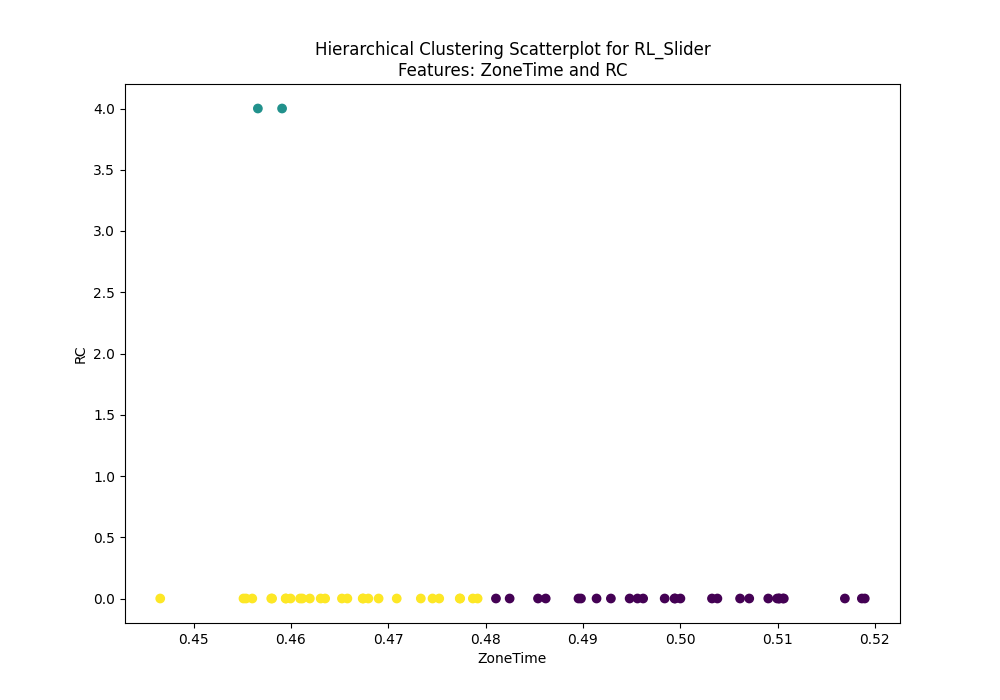

Scatterplot for RL_Slider


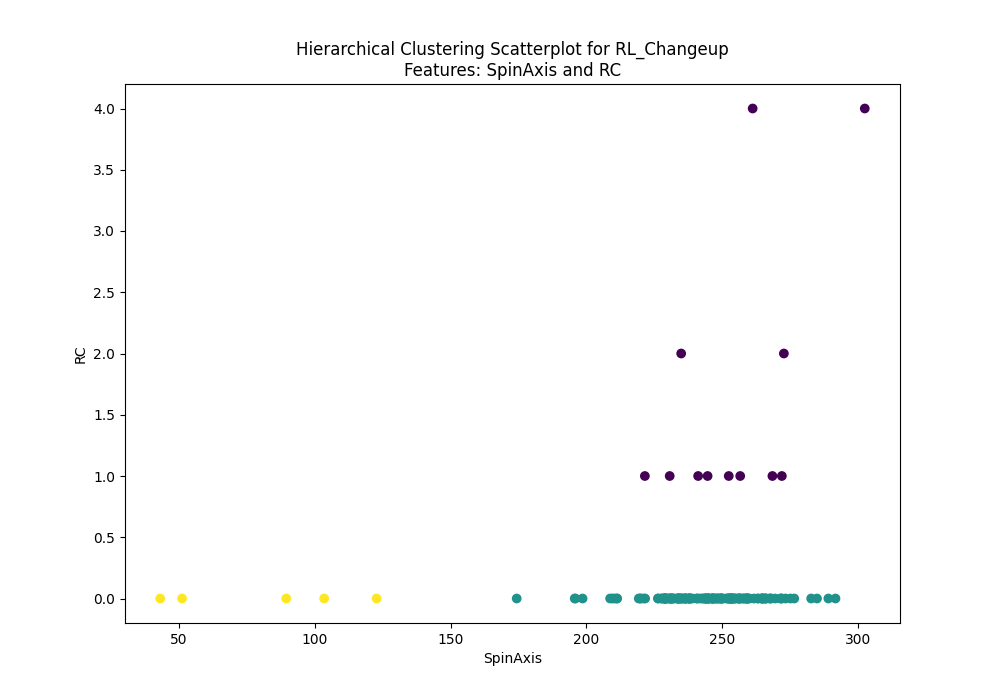

Scatterplot for RL_Changeup


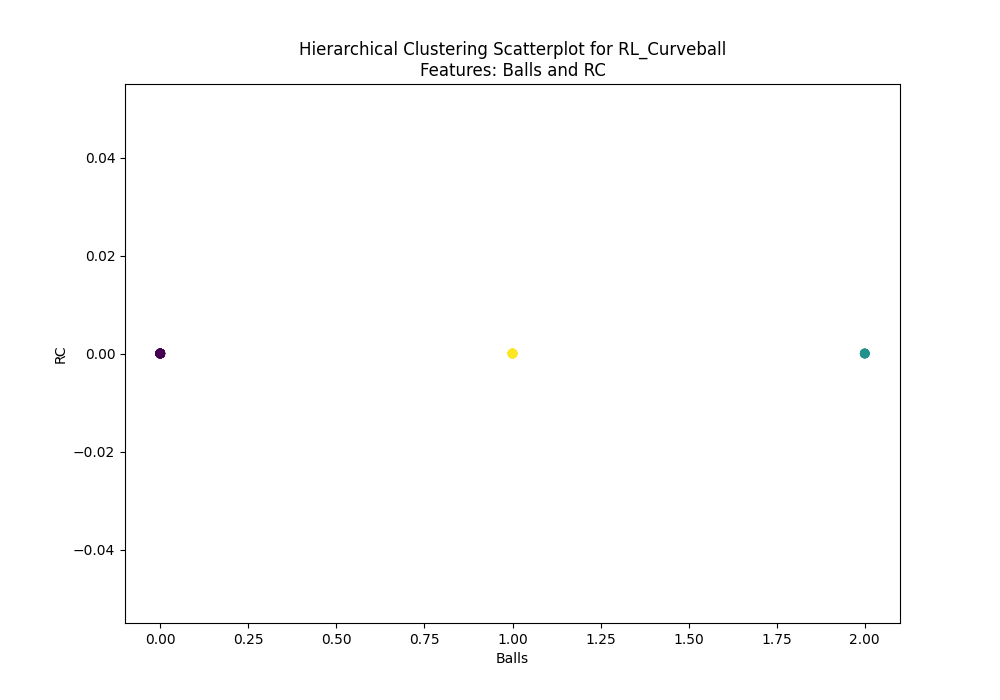

Scatterplot for RL_Curveball


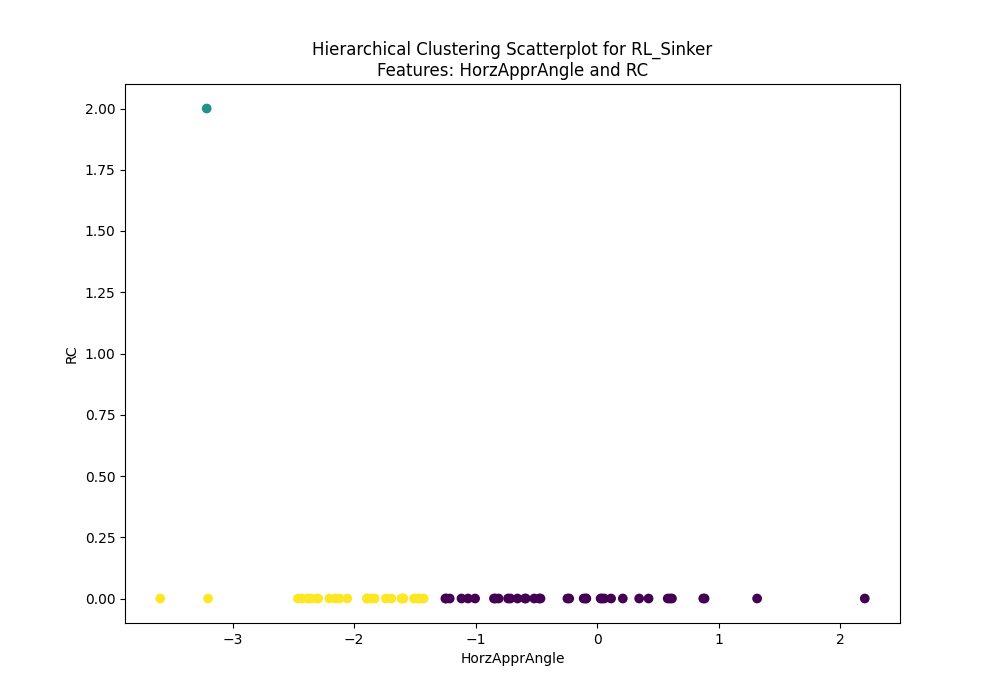

Scatterplot for RL_Sinker


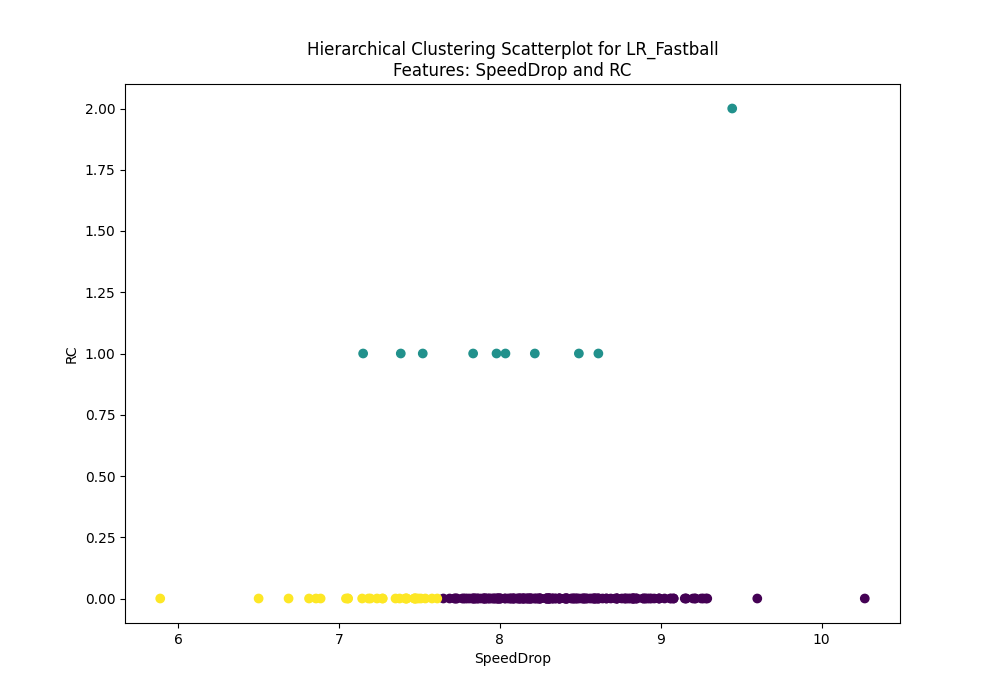

Scatterplot for LR_Fastball


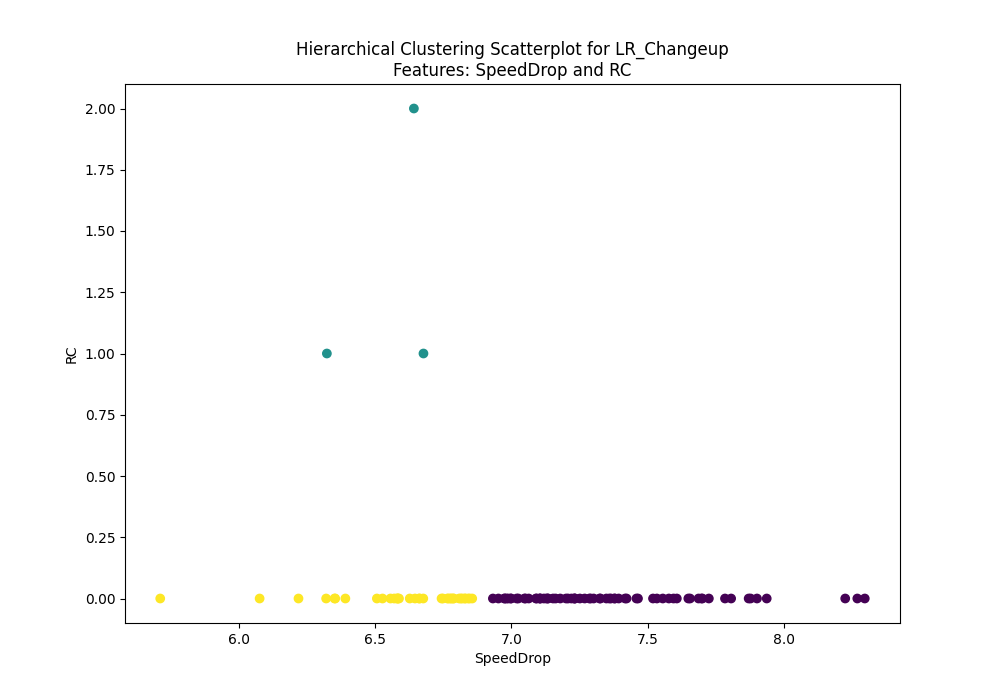

Scatterplot for LR_Changeup


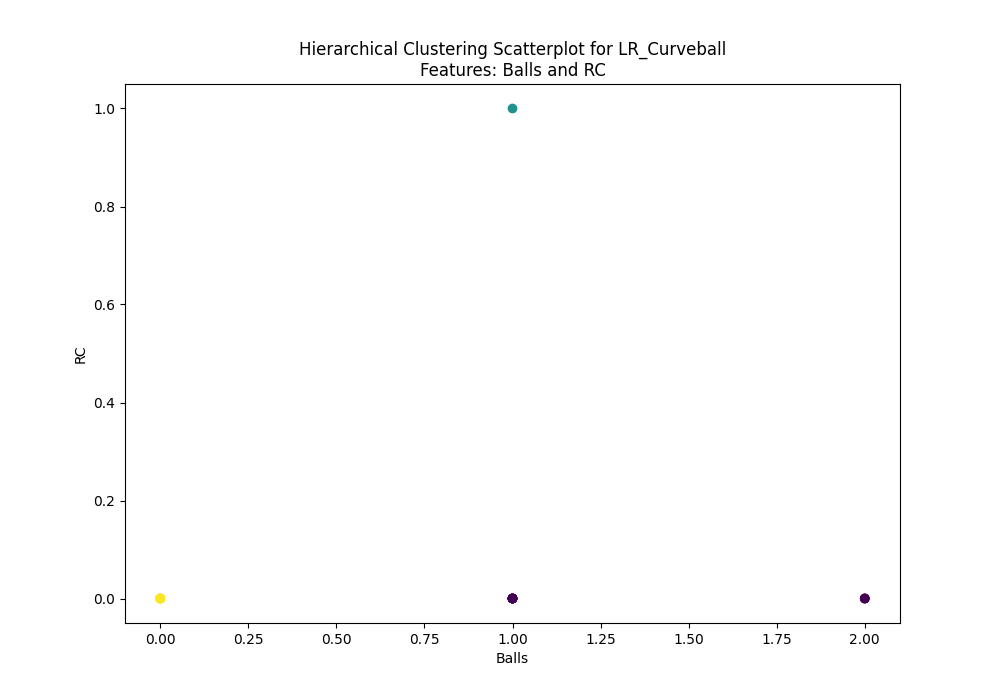

Scatterplot for LR_Curveball


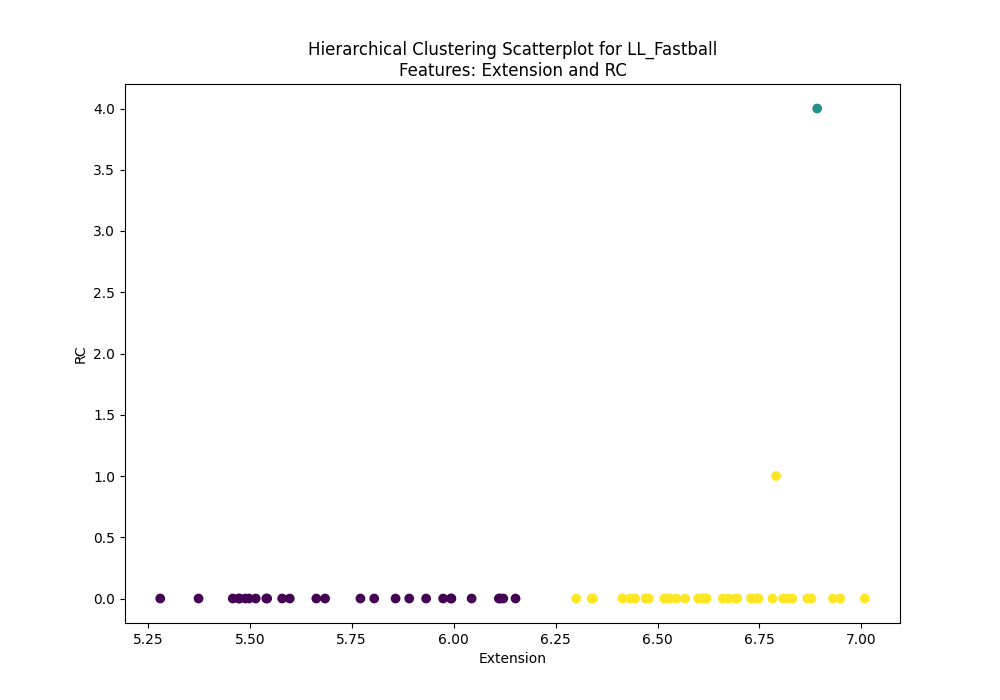

Scatterplot for LL_Fastball


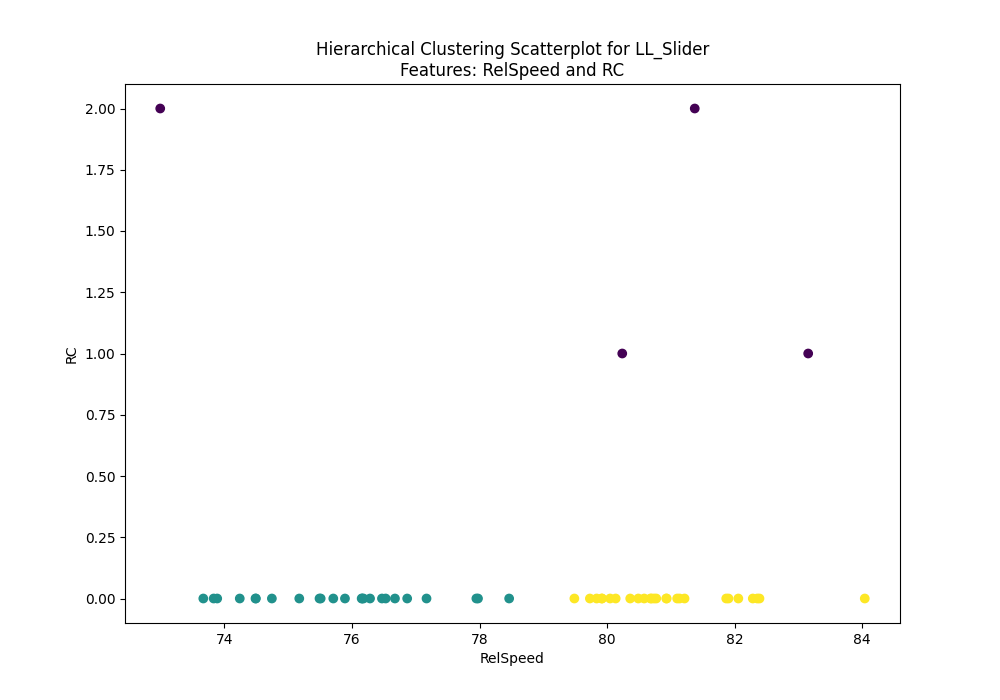

Scatterplot for LL_Slider


In [ ]:
from IPython.display import Image, display

for df_name in subset_dfs.keys():
    try:
        display(Image(filename=f'scatterplot_{df_name}.png'))
        print(f"Scatterplot for {df_name}")
    except FileNotFoundError:
        print(f"No Scatterplot found for {df_name}")

### Exit Velocity Random Forest Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    # Check if the DataFrame is not empty
    if not df.empty:

        # Prepare data for the model
        X = df.drop('ExitSpeed', axis=1)
        y = df['ExitSpeed']

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the Random Forest model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred = model.predict(X_test)

        # Evaluate the model's performance
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        print(f"Results for {df_name}:")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}")
        print(f"Important Features: {feature_importance}")
        print("-" * 20)  # Print a separator between results
    else:
        print(f"DataFrame {df_name} is empty. Skipping...")

Results for RR_Fastball:
Mean Squared Error: 1248.5707625520474
R-squared: 0.2630193832336353
Important Features:              Feature  Importance
12      PlateLocSide    0.213907
11    PlateLocHeight    0.136797
1            Strikes    0.076976
3       VertRelAngle    0.059063
14     HorzApprAngle    0.053103
2           RelSpeed    0.051527
4           SpinRate    0.046763
16         SpeedDrop    0.045258
9   InducedVertBreak    0.044455
15          ZoneTime    0.041635
5           SpinAxis    0.038851
8          Extension    0.037707
10         HorzBreak    0.035686
7            RelSide    0.034005
13     VertApprAngle    0.033276
6          RelHeight    0.033090
0              Balls    0.017904
--------------------
Results for RR_Slider:
Mean Squared Error: 1419.0237579902382
R-squared: -0.17176185008817324
Important Features:              Feature  Importance
4           SpinRate    0.141202
12      PlateLocSide    0.101068
5           SpinAxis    0.087311
8          Extension    0

### Pitch Efficiency Score Random Forests Model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    # Check if the DataFrame is not empty
    if not df.empty:

        # Prepare data for the model
        X = df.drop('StandardizedPES', axis=1)
        y = df['StandardizedPES']

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the Random Forest model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred = model.predict(X_test)

        # Evaluate the model's performance
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        print(f"Results for {df_name}:")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}")
        print(f"Important Features: {feature_importance}")
        print("-" * 20)  # Print a separator between results
    else:
        print(f"DataFrame {df_name} is empty. Skipping...")

Results for RR_Fastball:
Mean Squared Error: 5.759674344827652
R-squared: 0.30661717554531454
Important Features:              Feature  Importance
15         ExitSpeed    0.488958
14     HorzApprAngle    0.084219
12      PlateLocSide    0.077822
13     VertApprAngle    0.072668
11    PlateLocHeight    0.046764
0              Balls    0.040746
9   InducedVertBreak    0.028564
4           SpinRate    0.022094
10         HorzBreak    0.021303
3       VertRelAngle    0.020632
6          RelHeight    0.019466
8          Extension    0.018383
2           RelSpeed    0.018001
5           SpinAxis    0.017305
7            RelSide    0.015440
1            Strikes    0.007634
--------------------
Results for RR_Slider:
Mean Squared Error: 9.628020886792452
R-squared: 0.27357531442013583
Important Features:              Feature  Importance
15         ExitSpeed    0.377852
9   InducedVertBreak    0.090656
11    PlateLocHeight    0.078842
12      PlateLocSide    0.074531
4           SpinRate    0.0

### PES Graphs & Analysis

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Store Cluster Means for Later
cluster_means_dict = {}

# Function to perform hierarchical clustering and plot scatterplot
def perform_hierarchical_clustering(df, name):
    # Select RelSpeed and ExitSpeed
    data = df[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'HorzBreak', 'PlateLocSide', 'PlateLocHeight', 'SpinAxis', 'ExitSpeed', 'StandardizedPES']]

    # Replace infinite values with NaN
    data = data.replace([np.inf, -np.inf], np.nan)

    # Drop rows with NaN values
    data = data.dropna()

    # Keep only the rows in the original DataFrame that are also in the clustered data
    df = df.loc[data.index]

    # Standardize the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform hierarchical clustering
    n_clusters = 4  # You can adjust the number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = clustering.fit_predict(data_scaled)

    # Add the cluster labels as a new column to the DataFrame
    df['Cluster'] = clusters

    # Plot the scatterplot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(data['SpinRate'], data['StandardizedPES'], c=clusters, cmap='viridis')
    plt.title(f'Hierarchical Clustering Scatterplot for {name}\nFeatures: RelSpeed and StandardizedPES')
    plt.xlabel('RelSpeed')
    plt.ylabel('StandardizedPES')
    plt.colorbar(scatter, label='Cluster')
    plt.savefig(f'scatterplot_{name}.png')  # Save the plot as PNG
    plt.close()

    # Calculate cluster means for RelSpeed and StandardizedPES
    cluster_means = {}
    for cluster_id in range(n_clusters):
        cluster_means[cluster_id] = {
            'RelSpeed': data['RelSpeed'][clusters == cluster_id].mean(),
            'SpinRate': data['SpinRate'][clusters == cluster_id].mean(),
            'InducedVertBreak': data['InducedVertBreak'][clusters == cluster_id].mean(),
            'HorzBreak': data['HorzBreak'][clusters == cluster_id].mean(),
            'PlateLocSide': data['PlateLocSide'][clusters == cluster_id].mean(),
            'PlateLocHeight': data['PlateLocHeight'][clusters == cluster_id].mean(),
            'SpinAxis': data['SpinAxis'][clusters == cluster_id].mean(),
            'ExitSpeed': data['ExitSpeed'][clusters == cluster_id].mean(),
            'StandardizedPES': data['StandardizedPES'][clusters == cluster_id].mean()
        }

    # Return clustered data and cluster means # This line has been added to return the required values
    return data, cluster_means

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    required_columns = ['RelSpeed', 'SpinRate', 'InducedVertBreak', 'HorzBreak', 'PlateLocSide', 'PlateLocHeight', 'SpinAxis', 'ExitSpeed', 'StandardizedPES']

    # Check if the DataFrame is not empty, has at least 2 samples, and contains 'RelSpeed' and 'StandardizedPES' columns
    if not df.empty and len(df) >= 2 and 'RelSpeed' in df.columns and 'StandardizedPES' in df.columns:
        print(f"Processing {df_name}...")

        # Perform hierarchical clustering
        clustered_data, cluster_means = perform_hierarchical_clustering(df, df_name)

        # Store cluster means
        cluster_means_dict[df_name] = cluster_means
    else:
        print("Wrong Dataframe")

Processing RR_Fastball...
Processing RR_Slider...
Processing RR_Splitter...
Processing RR_Changeup...
Processing RR_Curveball...
Processing RR_Cutter...
Processing RR_Sinker...
Processing RL_Fastball...
Processing RL_Slider...
Processing RL_Changeup...
Processing RL_Curveball...
Processing RL_Sinker...
Processing LR_Fastball...
Processing LR_Changeup...
Processing LR_Curveball...
Processing LL_Fastball...
Processing LL_Slider...


#### Create a Table to display all of the Cluster Means (To **Right-Handed** Hitter)

Horizontal Thirds (**PlateLocSide**):

*   Inside third: -0.708 to -0.236
*   Middle third: -0.236 to 0.236
*   Outside third: 0.236 to 0.708  

Vertical Thirds (**PlateLocHeight**):
*   Lower third: 1.5 to 2.17
*   Middle third: 2.17 to 2.83
*   Upper third: 2.83 to 3.5

In [24]:
import pandas as pd

# Create a list to store all data
all_data = []

# Iterate through each pitch type and its cluster means
for pitch_type, means in cluster_means_dict.items():
    for cluster_id, row in means.items():
        all_data.append({
            'Pitch Type': pitch_type,
            'Cluster': cluster_id,
            'RelSpeed': row['RelSpeed'],
            'SpinRate': row['SpinRate'],
            'InducedVertBreak': row['InducedVertBreak'],
            'HorzBreak': row['HorzBreak'],
            'PlateLocSide': row['PlateLocSide'],
            'PlateLocHeight': row['PlateLocHeight'],
            'SpinAxis': row['SpinAxis'],
            'ExitSpeed': row['ExitSpeed'],
            'StandardizedPES': row['StandardizedPES']
        })

# Create a DataFrame from all_data
df_all_means = pd.DataFrame(all_data)

# Set 'Pitch Type' and 'Cluster' as multi-index
df_all_means.set_index(['Pitch Type', 'Cluster'], inplace=True)

# Sort the index
df_all_means.sort_index(inplace=True)
df_all_means = df_all_means.round(2)

df_all_means

RelSpeed  SpinRate  InducedVertBreak  HorzBreak  \
Pitch Type  Cluster                                                    
LL_Fastball 0           89.27   2213.89             18.24     -10.76   
            1           84.04   1978.39             10.49     -14.74   
            2           89.72   2197.30             18.13      -7.54   
            3           90.18   2250.35             17.98     -11.53   
LL_Slider   0           77.25   2167.90              2.88       6.57   
...                       ...       ...               ...        ...   
RR_Slider   3           81.59   2641.49              0.31      -8.86   
RR_Splitter 0           81.06   1078.32              4.82      13.25   
            1           83.09   1838.48              2.90     -12.10   
            2           84.09   1208.33              9.70      13.16   
            3           81.95    983.40              7.42      10.91   

                     PlateLocSide  PlateLocHeight  SpinAxis  ExitSpeed  \
Pitch Type  Cluster                                                      
LL_Fastball 0                0.63            2.20    147.87       0.29   
            1                0.03            2.59    123.00      13.88   
            2                0.09            2.04    156.09     102.78   
            3                0.03            2.64    145.86      73.34   
LL_Slider   0                0.58            2.25    255.19      18.48   
...                           ...             ...       ...        ...   
RR_Slider   3               -0.96            1.27     81.12       8.67   
RR_Splitter 0                0.58            1.83    254.66       7.25   
            1               -0.78            2.64    100.59      69.45   
            2               -0.46            0.34    237.96       0.00   
            3                0.24            2.14    239.97     100.35   

                     StandardizedPES  
Pitch Type  Cluster                   
LL_Fastball 0                 100.59  
            1                 100.54  
            2                  88.00  
            3                 101.20  
LL_Slider   0                 100.71  
...                              ...  
RR_Slider   3                 100.41  
RR_Splitter 0                 100.36  
            1                 101.65  
            2                  99.85  
            3                  89.55  

[68 rows x 9 columns]

#### Notes On Specific Matchups

| Matchup \ Pitch | Four-Seam Fastball |
|----------|:----------|
| RR | Clusters: 0 / Keys: Inner Third Location (Black/Ball In)|
| RL | Clusters: 1, 2 / Keys: Elite Vert (17-19), *Up/Out OR Low/In*  |
| LR | Clusters: 0 / Keys: Elite Vert (18+), *Up/In*|
| LL | Clusters: 1, 3 / Keys: 1 w/ Elite vert (19+), UP/Out Location ! 3 w/ Low vert (16), Some Run (-13), DOWN/Out |

 ------------------

| Matchup \ Pitch | Slider |
|----------|:----------|
| RR | Clusters: 1, 2 / Keys: 1 w/ Slower + Sweepy (78mph, 0-1V/9H) !  2 w/ Faster + Gyro (83mph, 6V/-3H)|
| RL | Clusters: 0, 2/ Keys: 0 w/ Gyro (4V/-4H) ! 2 w/ *(-1V)* Sweep (-9H) LOW |
| LR | N/A |
| LL | Clusters: 1, 2 / Keys: 1 w/ Huge Sweep (18H), INSIDE ! 2 w/ Gyro (3V/5H), LOW|

 ------------------

| Matchup \ Pitch | Changeup |
|----------|:----------|
| RR | Clusters: 1 / Keys: Unimpressive movement profile (12V/14H), Low/Outside |
| RL | Clusters: 0, 1 / Keys: Only difference btwn 1/2 is location: **Miss DOWN** ! 0? |
| LR | Clusters: 0, 2, 3 / Keys: Extremely Successful Pitch ! Only hot zone i middle/middle|
| LL | N/A|

 ------------------

| Matchup \ Pitch | Curveball |
|----------|:----------|
| RR | Clusters: 2, 3 / Keys: Super Successful Pitch Matchup, keep to black/ball down|
| RL | Clusters: 1, 2 / Keys: Also Successful Pitch Matchup, Needs vert (-15)|
| LR | Clusters: / Keys:|
| LL | N/A|

 ------------------

| Matchup \ Pitch | Sinker |
|----------|:----------|
| RR | Clusters: 1 / Keys: All get hit ! |
| RL | Clusters: / Keys:|
| LR | Clusters: / Keys:|
| LL | N/A|

 ------------------

| Matchup \ Pitch | Cutter |
|----------|:----------|
| RR | Clusters: / Keys:|
| RL | Clusters: / Keys:|
| LR | Clusters: / Keys:|
| LL | N/A|

 ------------------

| Matchup \ Pitch | Splitter |
|----------|:----------|
| RR | Clusters: / Keys:|
| RL | Clusters: / Keys:|
| LR | Clusters: / Keys:|
| LL | N/A|

Scatterplot for RR_Fastball


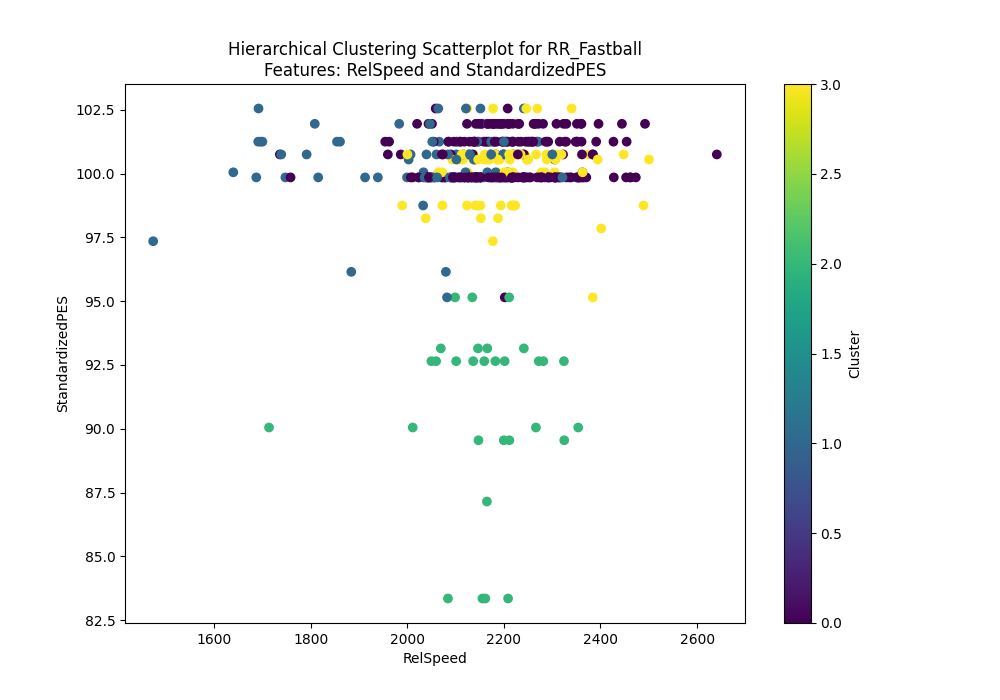

Scatterplot for RR_Slider


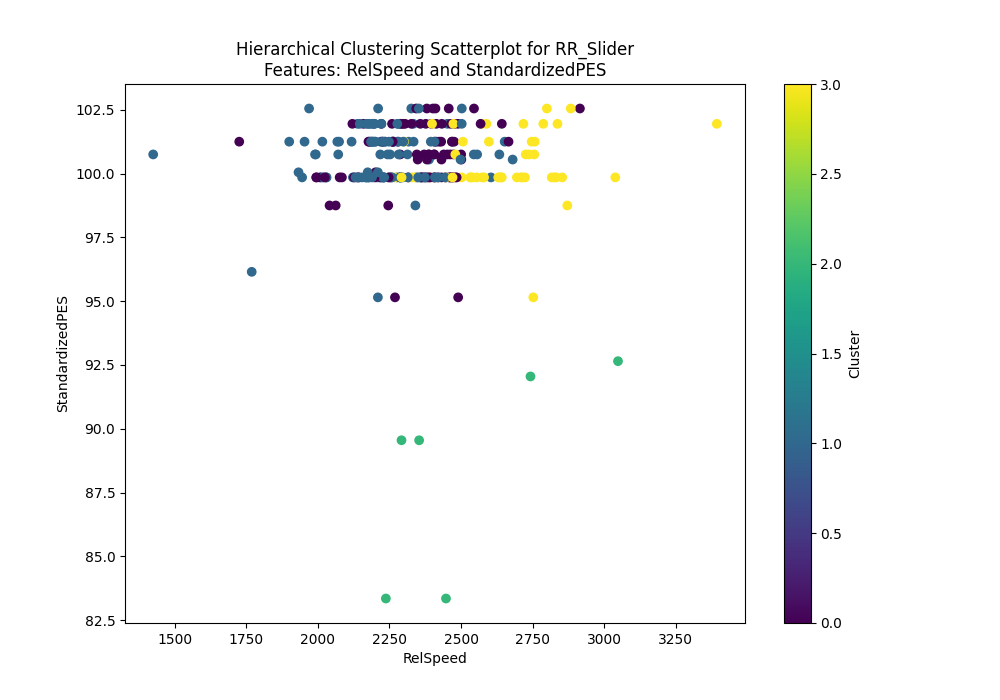

Scatterplot for RR_Splitter


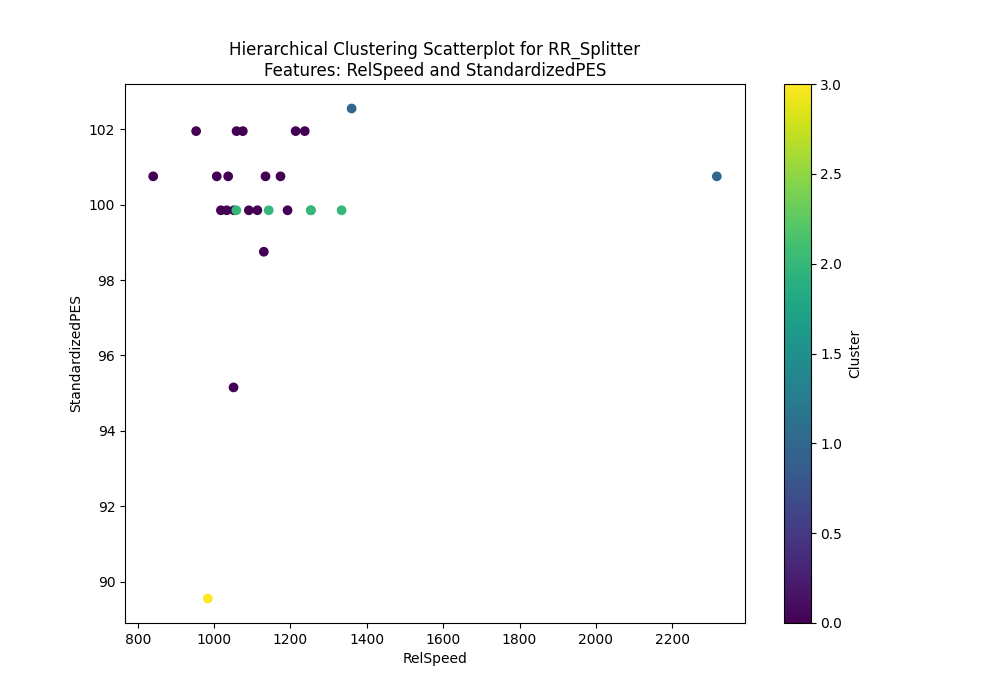

Scatterplot for RR_Changeup


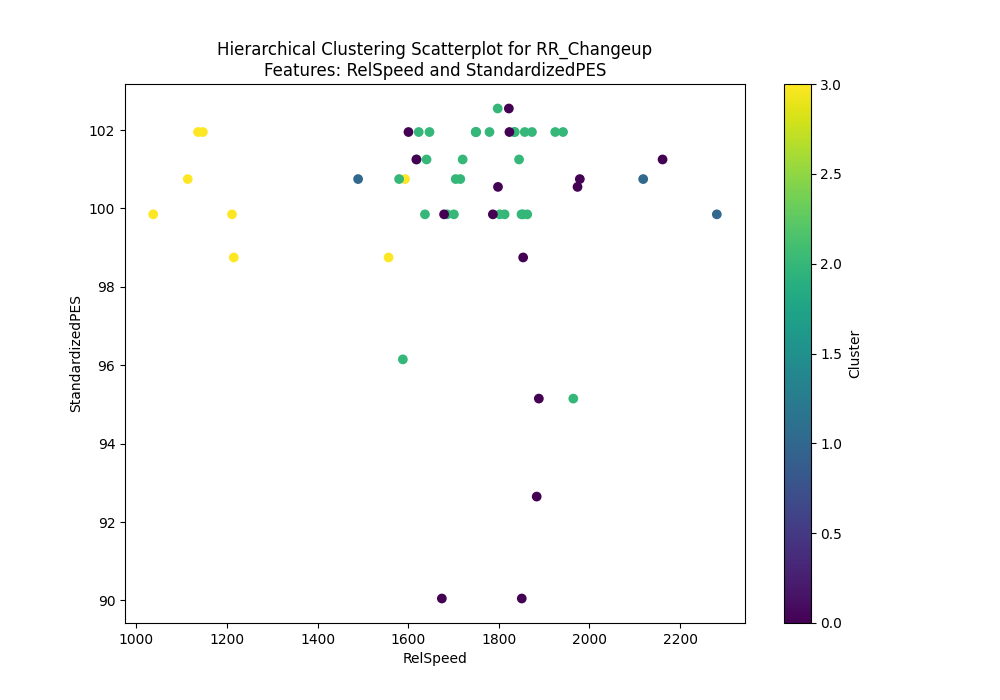

Scatterplot for RR_Curveball


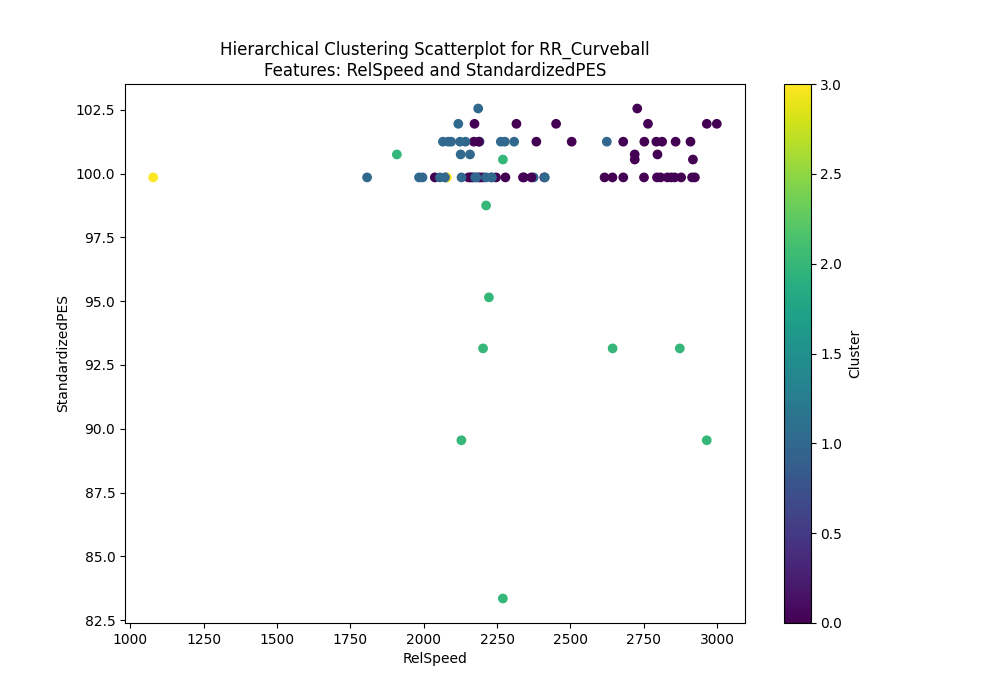

Scatterplot for RR_Cutter


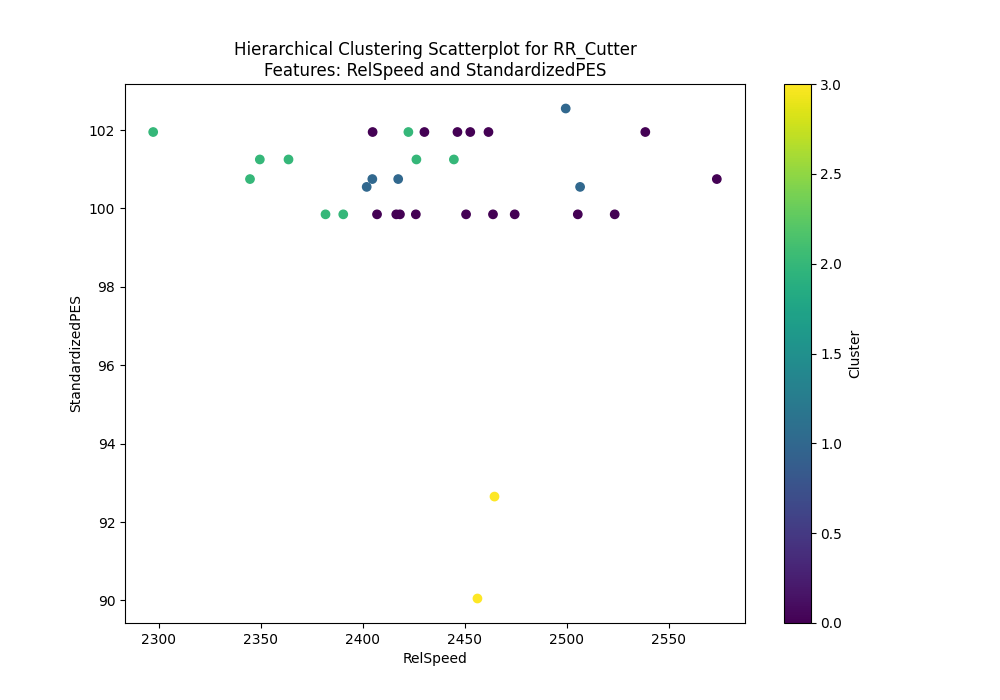

Scatterplot for RR_Sinker


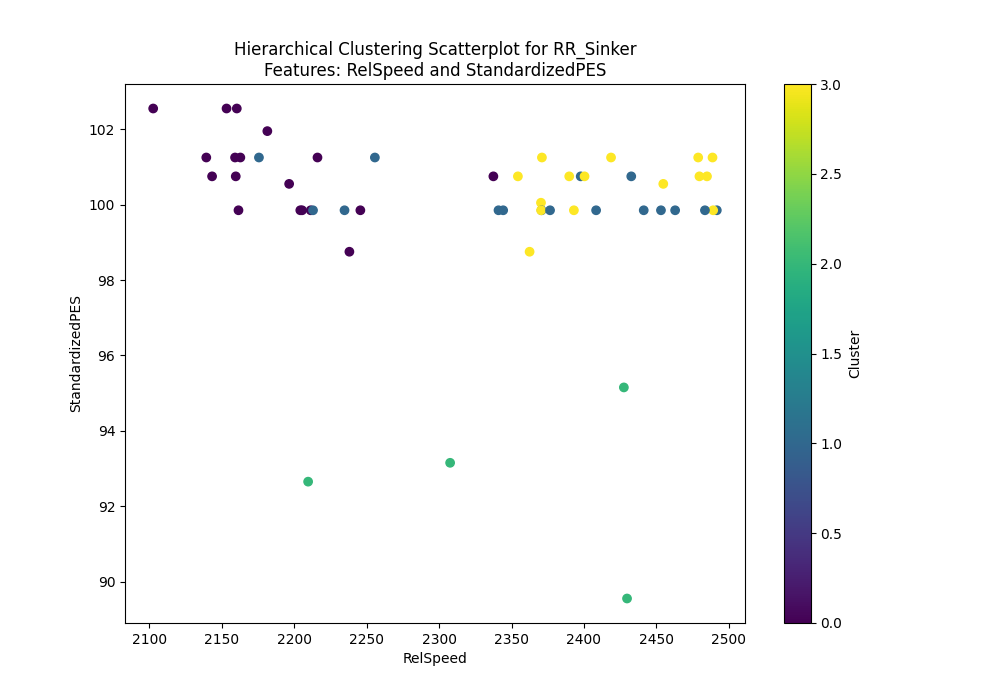

Scatterplot for RL_Fastball


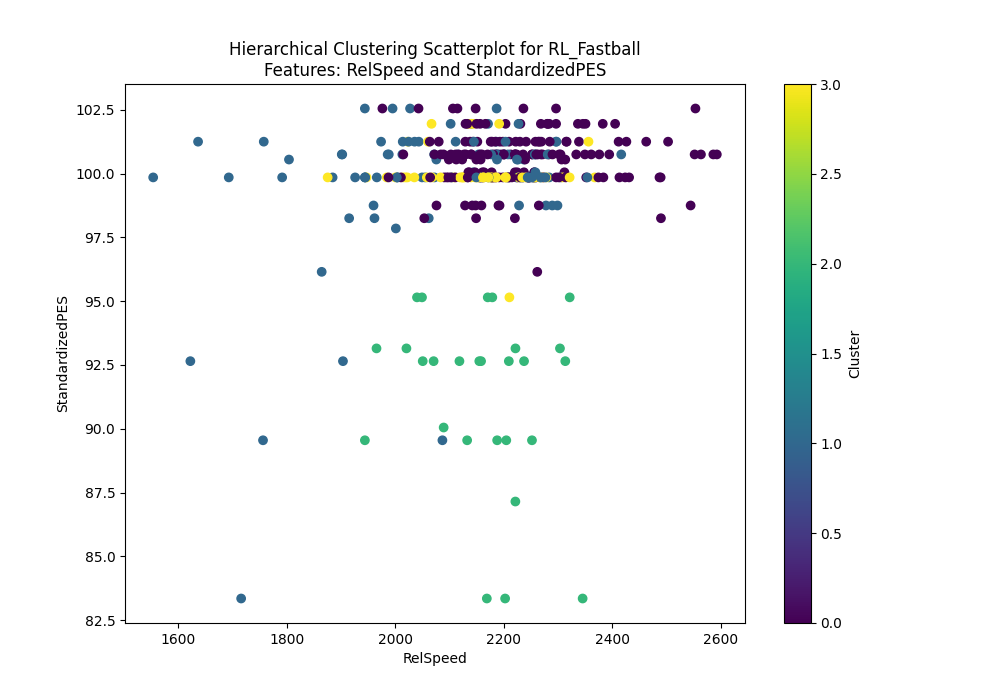

Scatterplot for RL_Slider


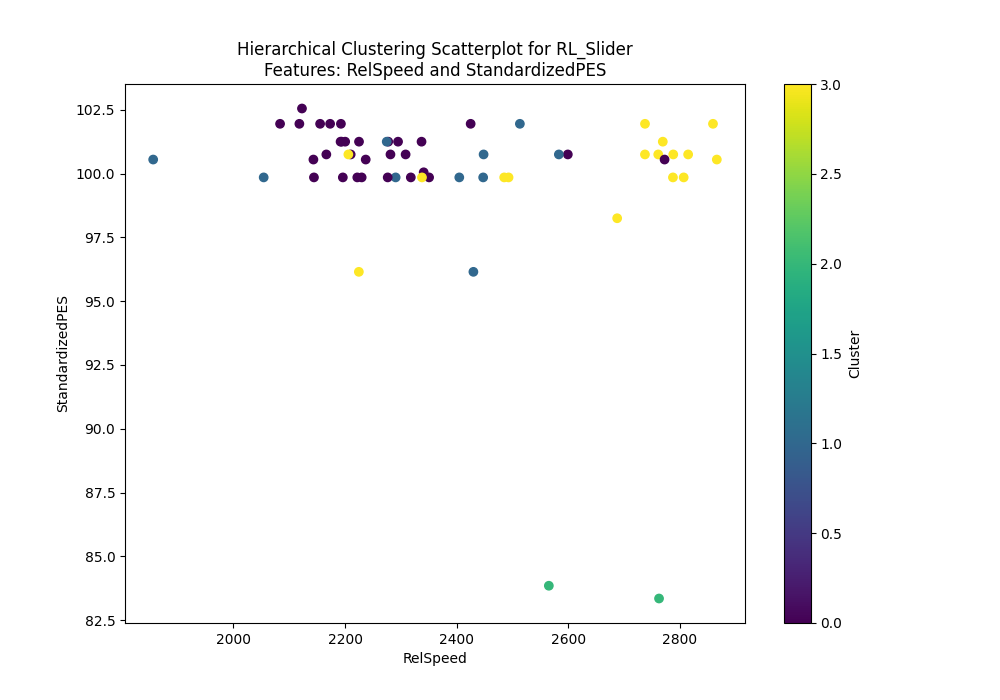

Scatterplot for RL_Changeup


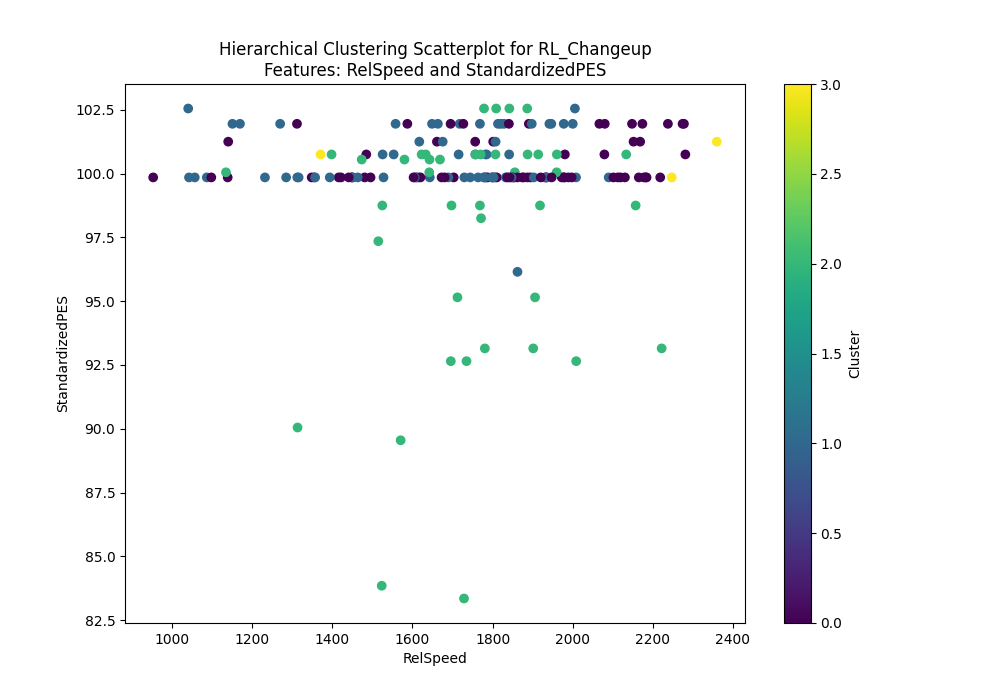

Scatterplot for RL_Curveball


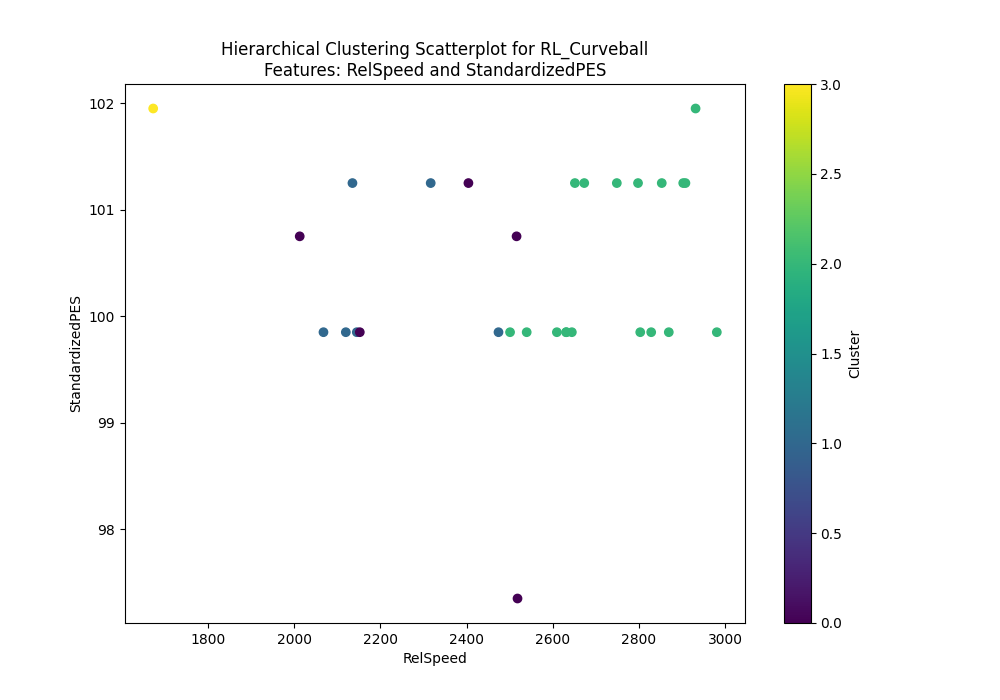

Scatterplot for RL_Sinker


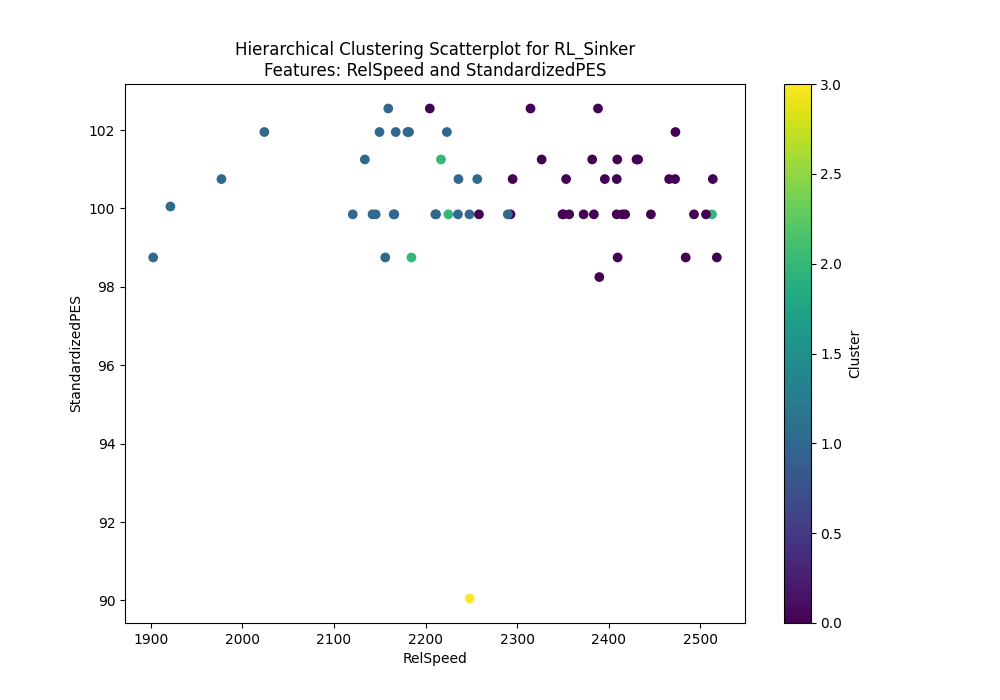

Scatterplot for LR_Fastball


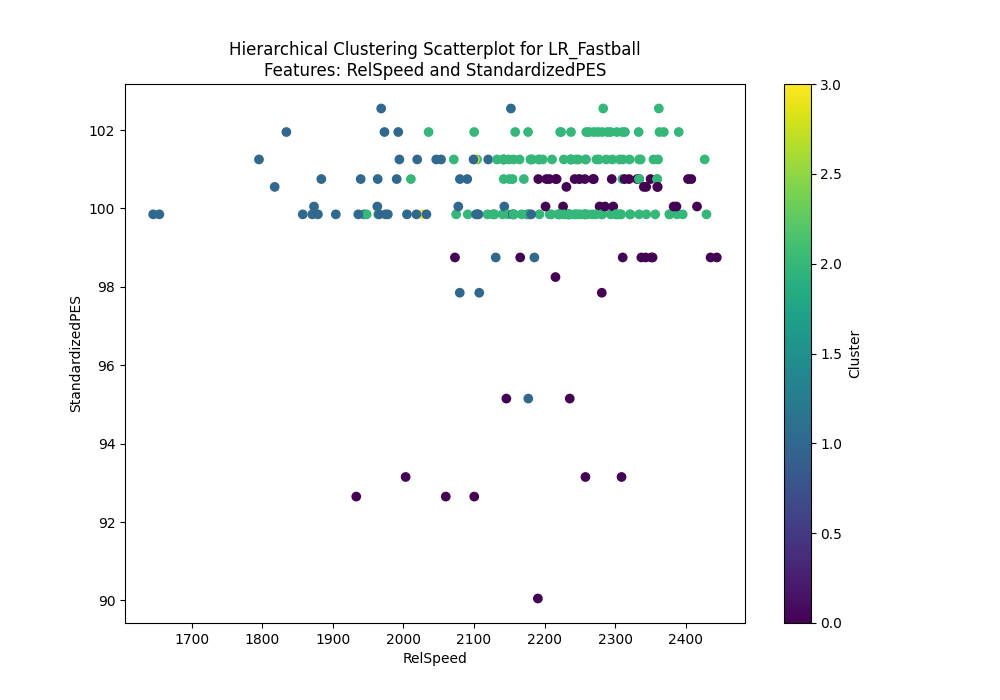

Scatterplot for LR_Changeup


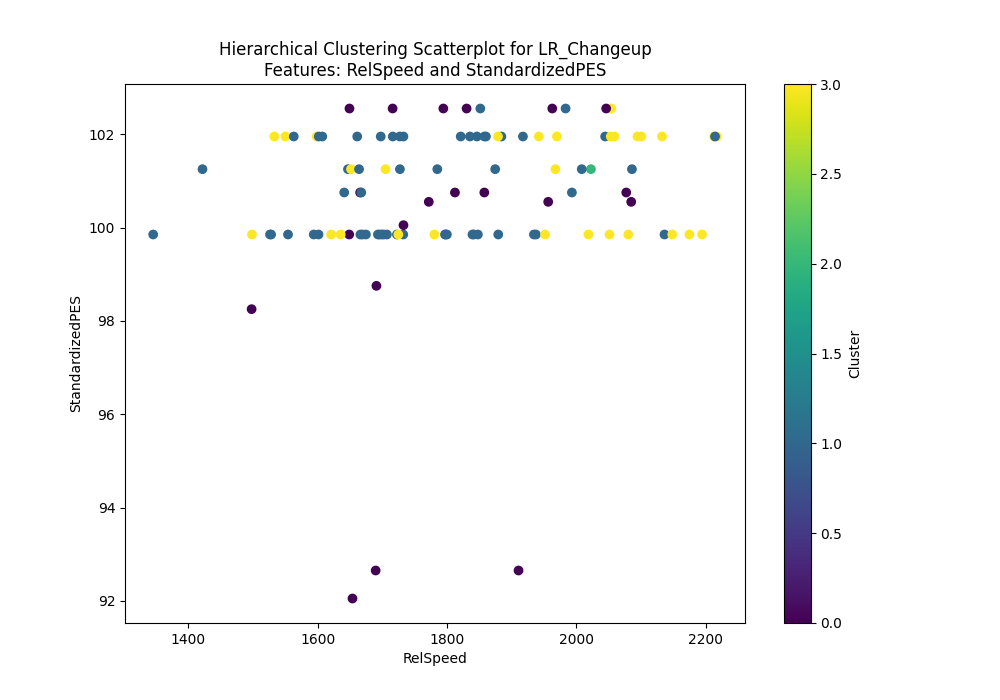

Scatterplot for LR_Curveball


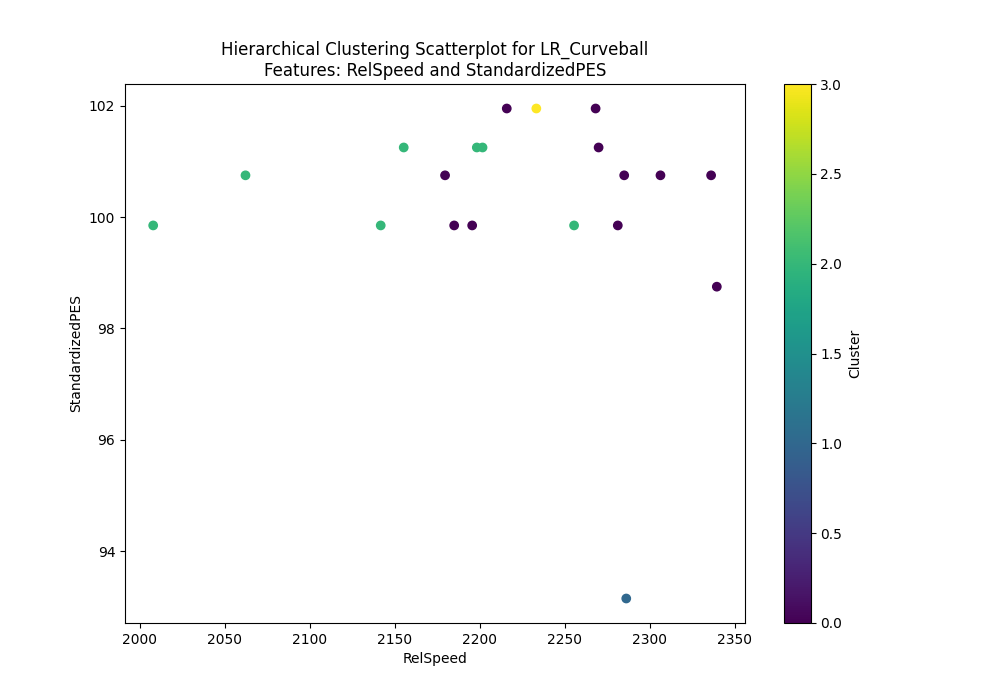

Scatterplot for LL_Fastball


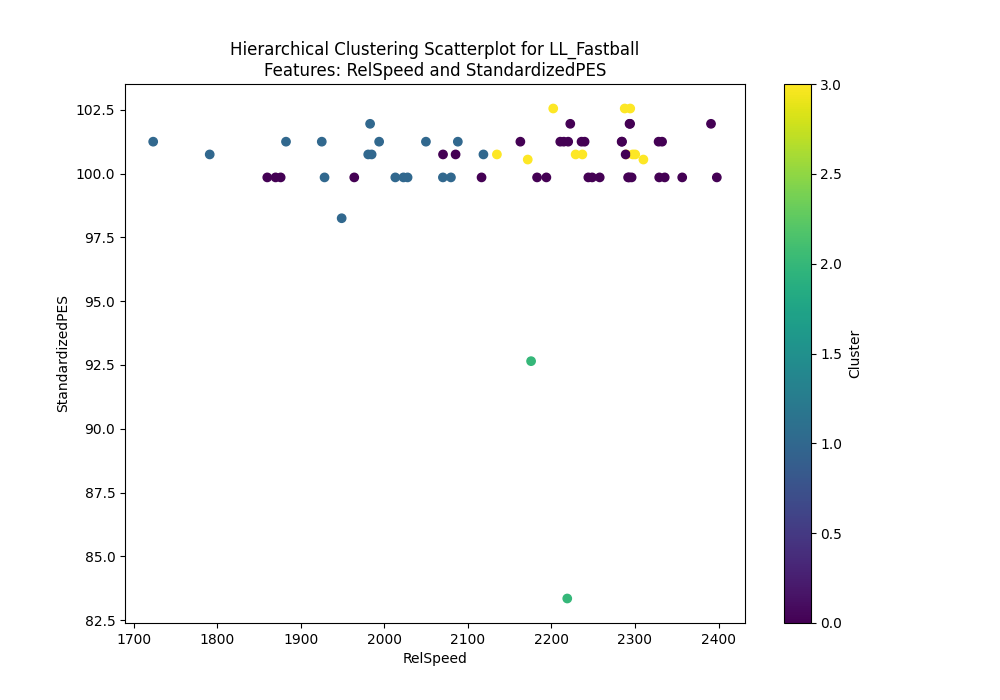

Scatterplot for LL_Slider


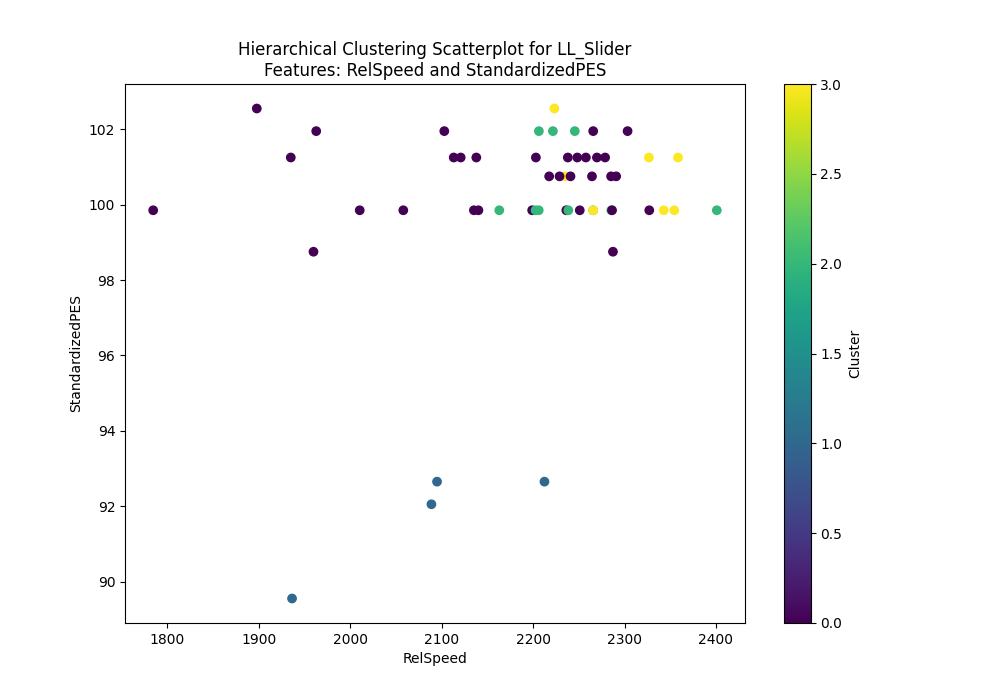

In [25]:
from IPython.display import Image, display

for df_name in subset_dfs.keys():
    try:
        print(f"Scatterplot for {df_name}")
        display(Image(filename=f'scatterplot_{df_name}.png'))
    except FileNotFoundError:
        print(f"No Scatterplot found for {df_name}")